In [62]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils



### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just message)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that replied to the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [5]:

# path for dataset
path = '../../../anonymized/'
loader = SlackDataLoader(path)



In [6]:
def create_df():
    all_channels = loader.get_channels()
    channel_names = [channel['name'] for channel in all_channels]

    df = []
    for name in channel_names:
        channel_path = path + name + '/'
        channel_df = loader.slack_parser(channel_path)
        df.append(channel_df)
    
    all_df = pd.concat(df)
    return all_df

In [7]:
df = create_df()
df

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,same! what's got a lot of holes but still hold...,Elizabeth Hall,1661420476.890989,text,1661343150.595419,0,0,0,0,
1,message,<@U03TEPYRM2P>,Nancy Craig,1661423005.712039,user,1661423005.712039,1,1,U03TEPYRM2P,1661423028.780879,
2,message,I am with you,Garrett Bell,1661423028.780879,text,1661423005.712039,0,0,0,0,
3,message,*<!here> Community Building Session REMINDER!*...,Vanessa Norman,1661428200.705819,broadcast,0,0,0,0,0,
4,message,Join the Call,Vanessa Norman,1661428630.743209,text,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
0,message,<https://developer.algorand.org/solutions/mint...,Katie Dickerson,1668359175.400459,link,0,0,0,0,0,
1,message,<https://developer.algorand.org/solutions/mint...,Katie Dickerson,1668359175.400459,link,0,0,0,0,0,
2,message,How can I get the trainees that opted-in a giv...,Katie Dickerson,1668272023.894179,text,0,0,0,0,0,
3,message,<https://developer.algorand.org/solutions/mint...,Katie Dickerson,1668359175.400459,link,0,0,0,0,0,


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

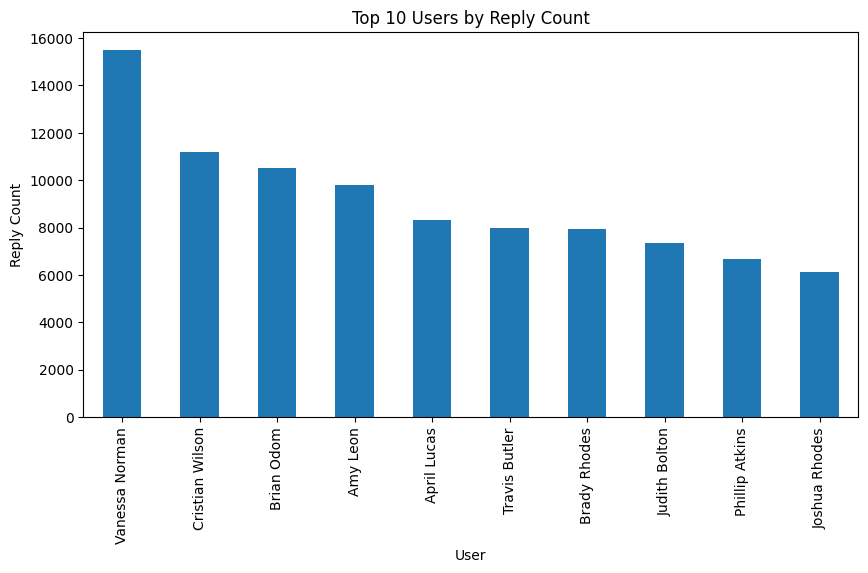

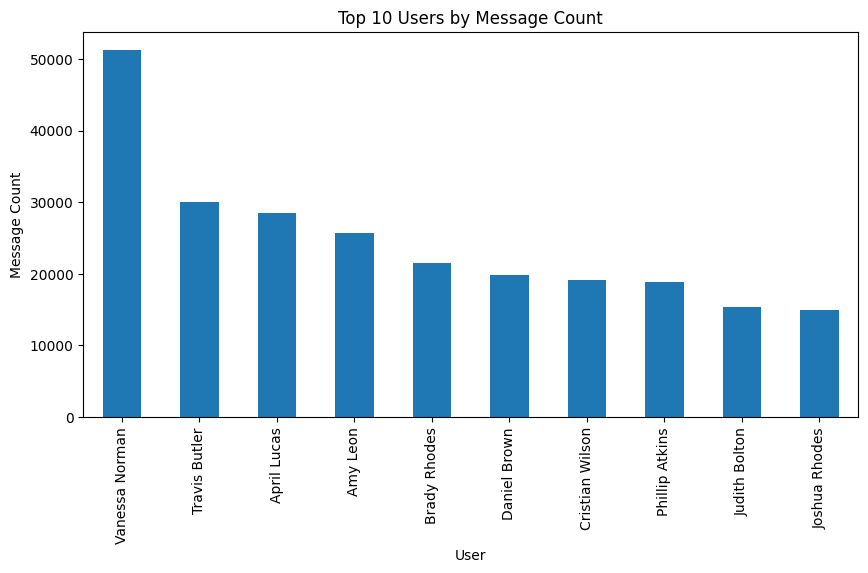

In [8]:
# which user has the highest number of reply counts?

top_10_reply = df.groupby('sender_name')['reply_count'].sum().nlargest(10)
bottom_10_reply = df.groupby('sender_name')['reply_count'].sum().nsmallest(10)

# Top and bottom 10 users by message count
top_10_msg = df['sender_name'].value_counts().nlargest(10)
bottom_10_msg = df['sender_name'].value_counts().nsmallest(10)

# Top 10 users by reply count
plt.figure(figsize=(10,5))
top_10_reply.plot(kind='bar')
plt.title('Top 10 Users by Reply Count')
plt.xlabel('User')
plt.ylabel('Reply Count')
plt.show()

# Top 10 users by message count
plt.figure(figsize=(10,5))
top_10_msg.plot(kind='bar')
plt.title('Top 10 Users by Message Count')
plt.xlabel('User')
plt.ylabel('Message Count')
plt.show()



In [9]:
# Count the number of messages in each channel
channel_activity = df['channel'].value_counts()

# The channel with the highest activity
most_active_channel = channel_activity.idxmax()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    481344
Name: channel, dtype: int64


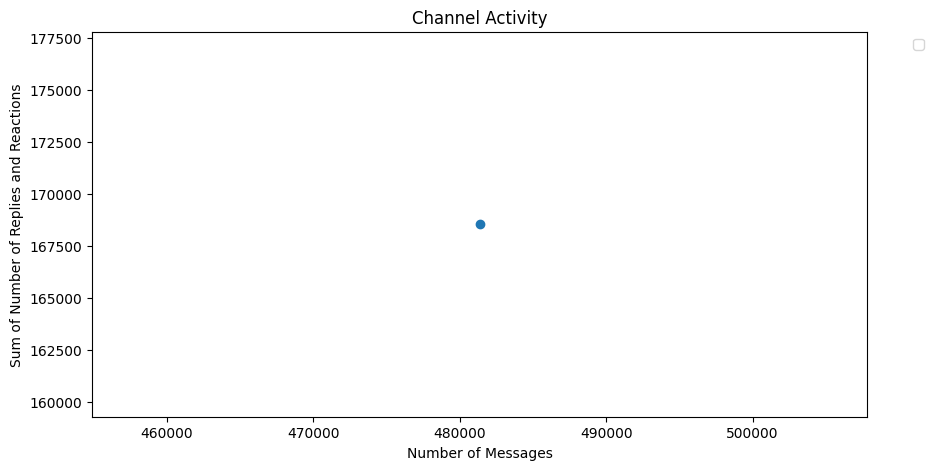

In [10]:
# Calculate the sum of number of replies and reactions for each channel
df['activity_sum'] = df['reply_count']
channel_activity_sum = df.groupby('channel')['activity_sum'].sum()

# Number of messages in each channel
channel_msg_count = df['channel'].value_counts()
print(channel_msg_count)
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Message Count': channel_msg_count,
    'Activity Sum': channel_activity_sum
})

# Create a scatter plot
plt.figure(figsize=(10, 5))
for channel in plot_df.index:
    plt.scatter(plot_df.loc[channel, 'Message Count'], plot_df.loc[channel, 'Activity Sum'], label=channel)
plt.xlabel('Number of Messages')
plt.ylabel('Sum of Number of Replies and Reactions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Channel Activity')
plt.show()

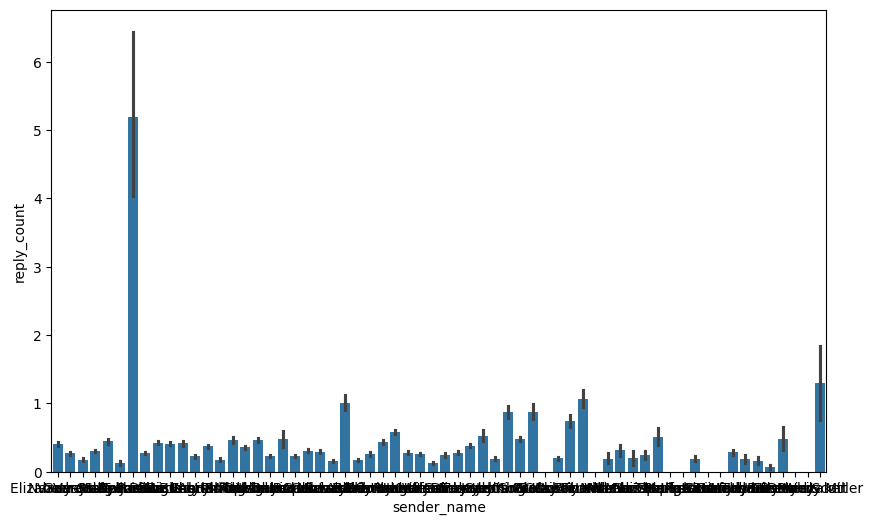

In [11]:
# Visualize reply counts per user per channel
plt.figure(figsize=(10,6))
sns.barplot(x='sender_name', y='reply_count', hue='channel', data=df)
plt.show()

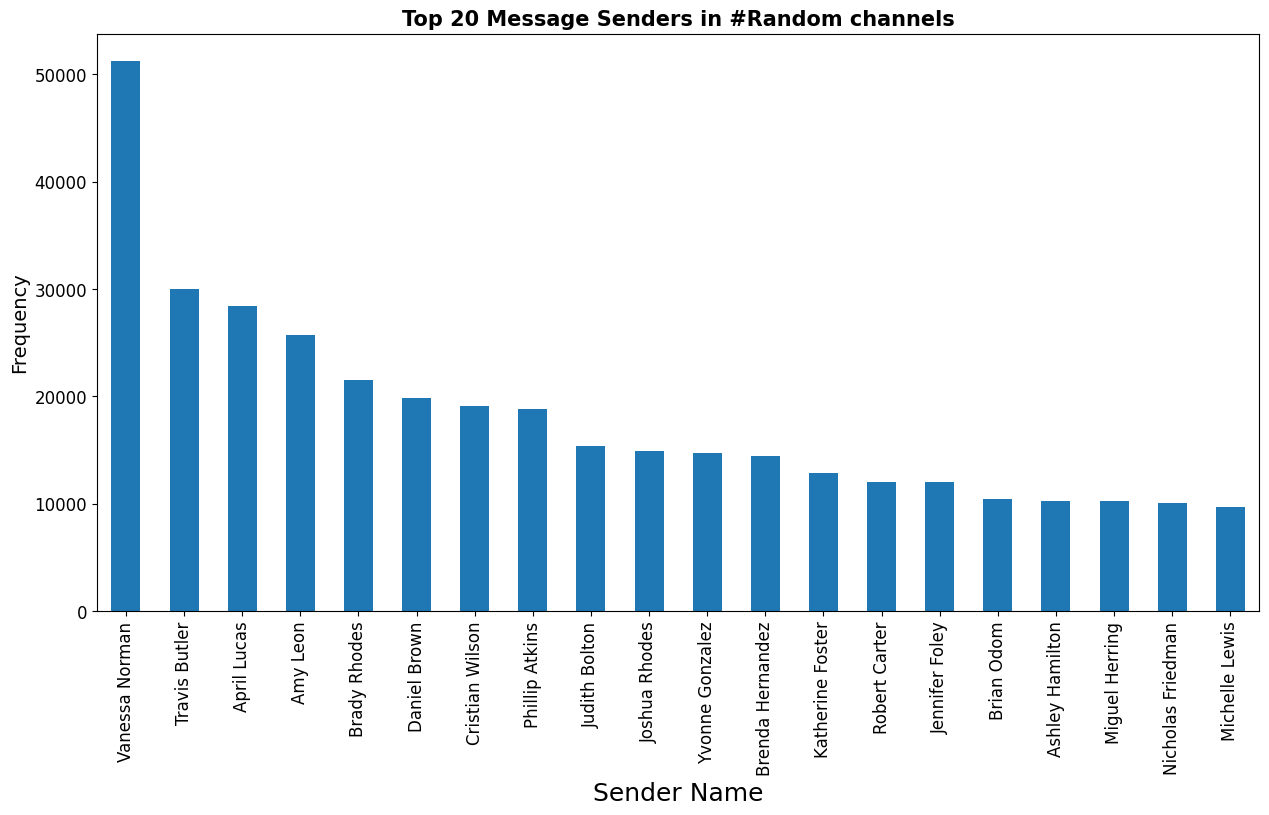

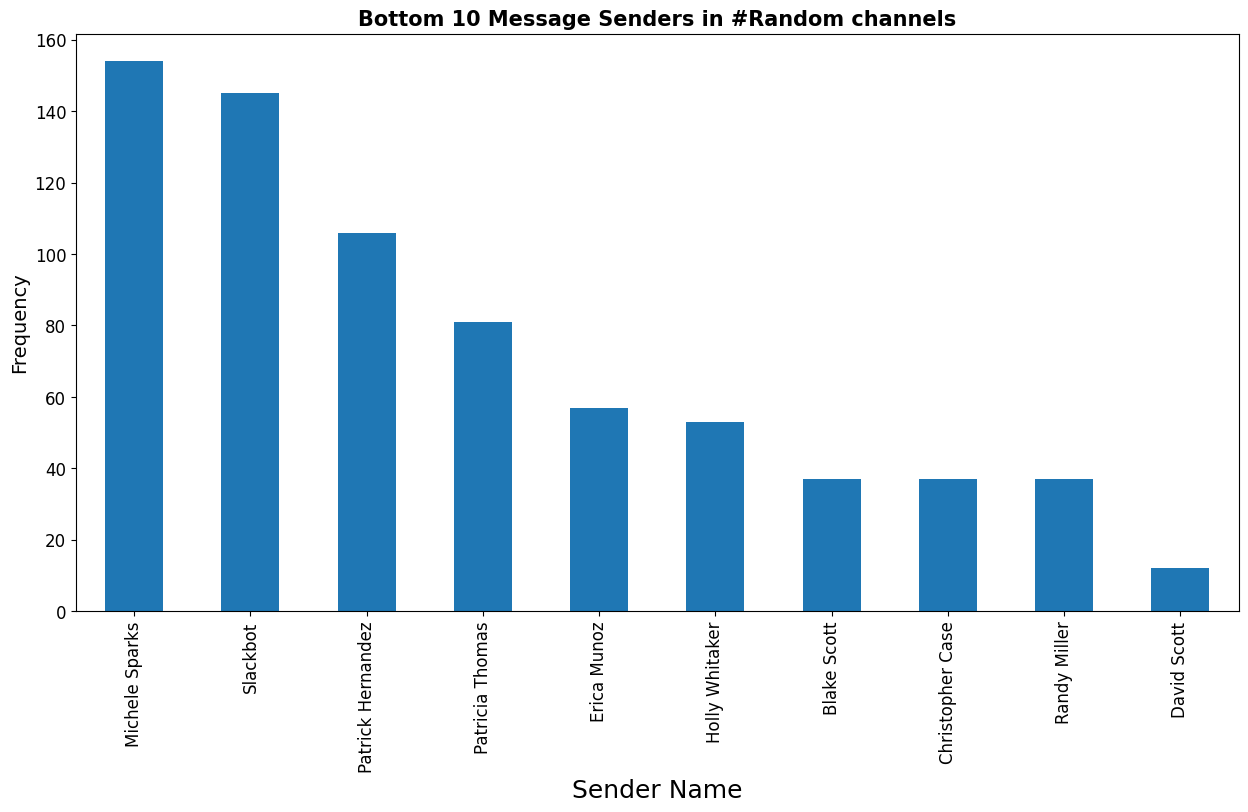

In [17]:
get_top_20_user(df, 'Random')

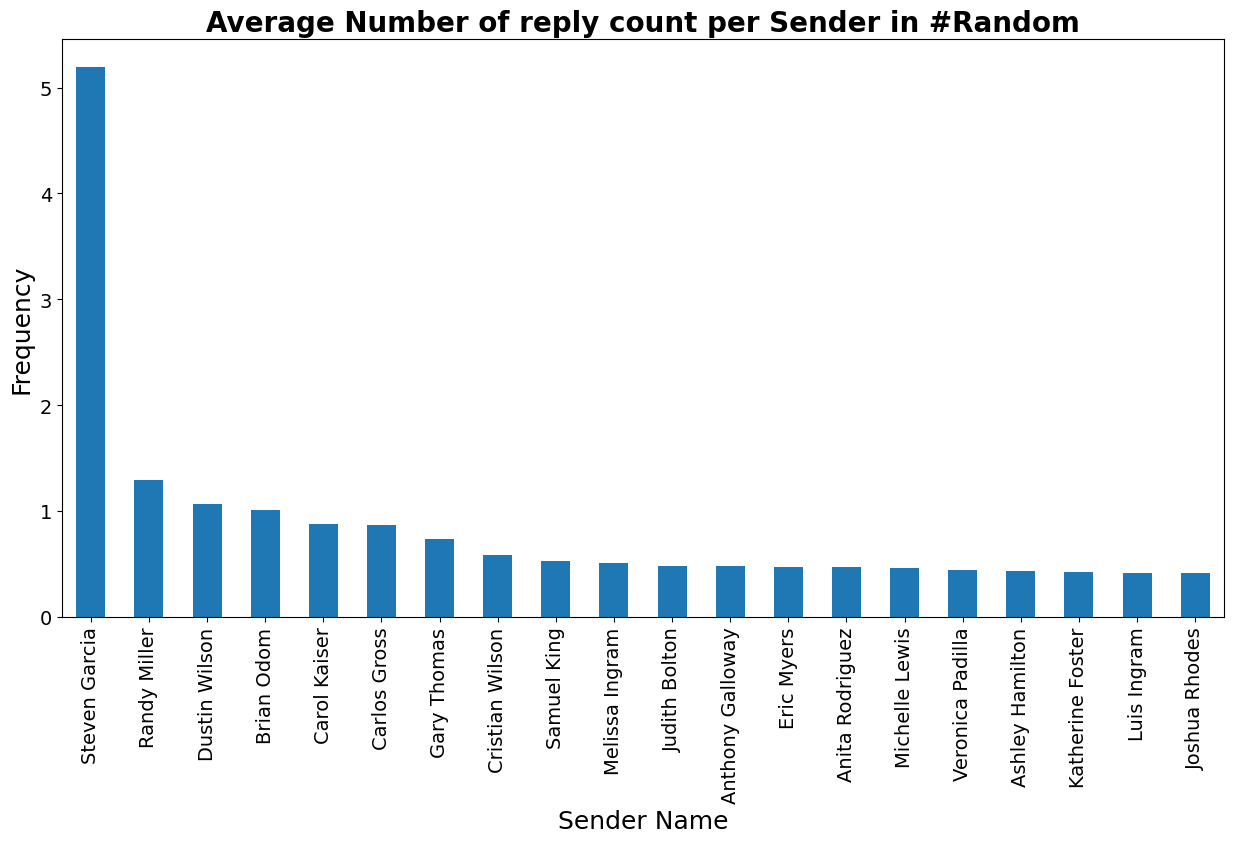

In [18]:
draw_avg_reply_count(df, 'Random')

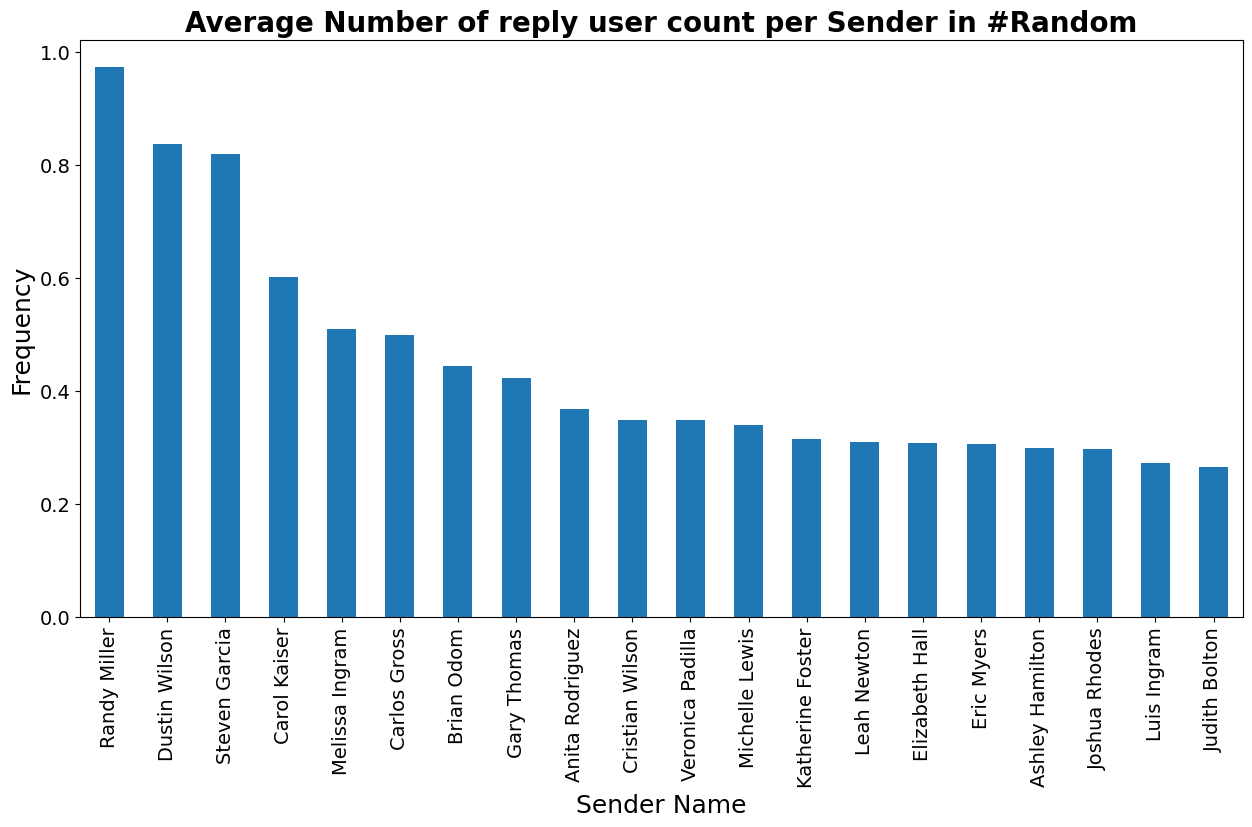

In [19]:
draw_avg_reply_users_count(df, 'Random')

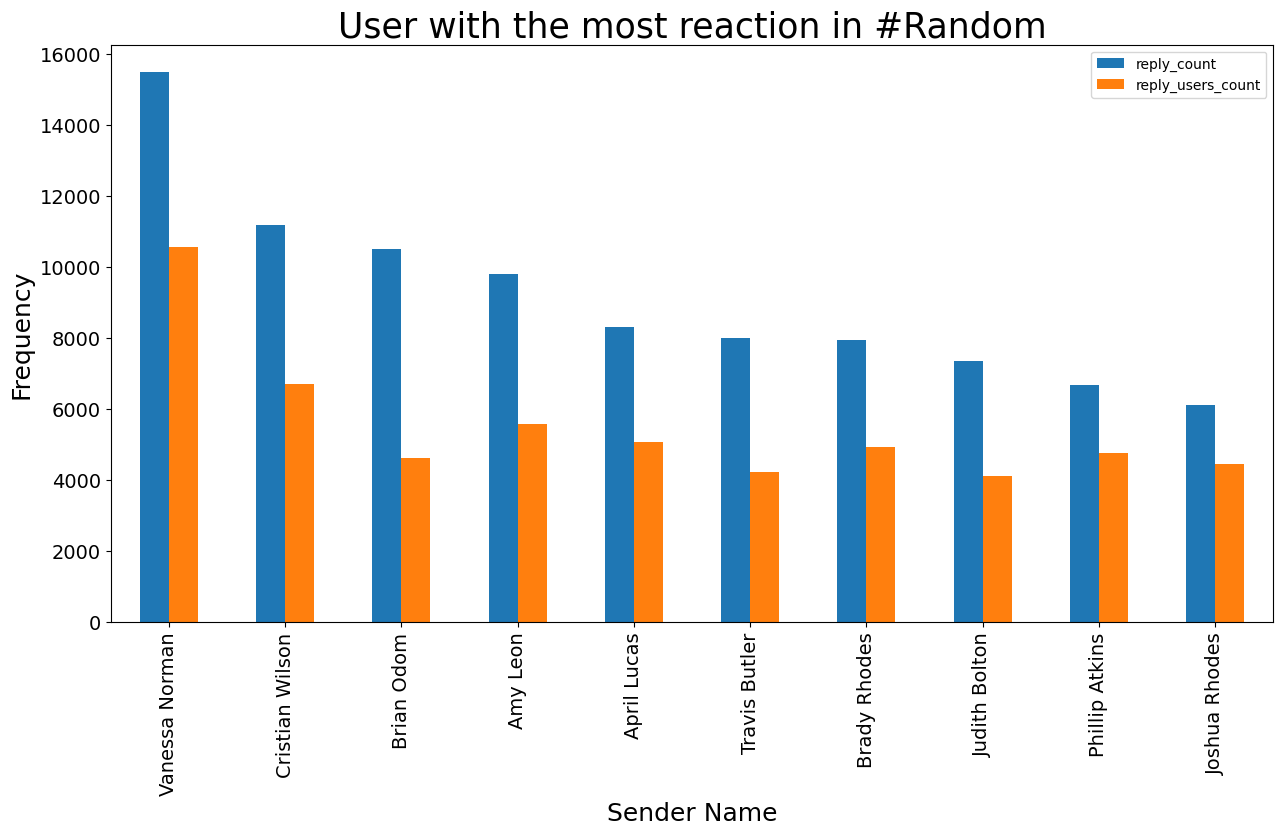

In [20]:
draw_user_reaction(df, 'Random')

In [ ]:
# distribution of time differences between messages, and replies
df = df.sort_values('msg_sent_time')

# Calculate time difference between consecutive messages in minutes
df['time_diff'] = df['msg_sent_time'].diff() / 60

# Remove the first row (NaN value)
df = df.iloc[1:]

# Plot histogram of time differences for messages
plt.hist(df['time_diff'], bins=50, alpha=0.5, label='Messages')

plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [12]:
# what is the time range of the day that most messages are sent?


In [13]:
# what kind of messages are replied faster than others?


In [16]:
# Create a new DataFrame with the required information


In [15]:
# Relationship between # of messages and # of reactions


In [16]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [17]:
# Which users got the most reactions?

In [33]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?